<a href="https://colab.research.google.com/github/pachterlab/CBP_2021/blob/main/notebooks/allInterIntraDistortions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!date

Mon Sep 13 21:09:15 UTC 2021


In [1]:
import requests
import os


In [2]:
#Download datasets




from tqdm import tnrange, tqdm_notebook
def download_file(doi,ext):
	url = 'https://api.datacite.org/dois/'+doi+'/media'
	r = requests.get(url).json()
	netcdf_url = r['data'][0]['attributes']['url']
	r = requests.get(netcdf_url,stream=True)
	#Set file name
	fname = doi.split('/')[-1]+ext
	#Download file with progress bar
	if r.status_code == 403:
		print("File Unavailable")
	if 'content-length' not in r.headers:
		print("Did not get file")
	else:
		with open(fname, 'wb') as f:
			total_length = int(r.headers.get('content-length'))
			pbar = tnrange(int(total_length/1024), unit="B")
			for chunk in r.iter_content(chunk_size=1024):
				if chunk:
					pbar.update()
					f.write(chunk)
		return fname



#SMART-seq VMH data
#metadata.csv
download_file('10.22002/D1.2067','.gz')

#smartseq.mtx (log counts)
download_file('10.22002/D1.2071','.gz')



#MERFISH data
#metadata.csv
download_file('10.22002/D1.2063','.gz')

#counts.h5ad
download_file('10.22002/D1.2064','.gz')





os.system("gunzip *.gz")



os.system("mv D1.2067 smartmetadata.csv")
os.system("mv D1.2071 smartseq.mtx")

os.system("mv D1.2063 metadata.csv")
os.system("mv D1.2064 counts.h5ad")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`


  0%|          | 0/64 [00:00<?, ?B/s]

  0%|          | 0/26700 [00:00<?, ?B/s]

  0%|          | 0/9784 [00:00<?, ?B/s]

  0%|          | 0/59360 [00:00<?, ?B/s]

0

In [3]:
#Read in files from NCBI GEO
os.system("wget --quiet https://ftp.ncbi.nlm.nih.gov/geo/series/GSE149nnn/GSE149372/suppl/GSE149372_scRNA.MetaData.85.csv.gz")
os.system("wget --quiet https://ftp.ncbi.nlm.nih.gov/geo/series/GSE149nnn/GSE149372/suppl/GSE149372_scRNA.normalized.assay85.csv.gz")

0

In [4]:
os.system("git clone https://github.com/hhcho/densvis.git")

0

In [5]:
%cd ./densvis/densne/


!g++ sptree.cpp densne.cpp densne_main.cpp -o den_sne -O2
import densne

/content/densvis/densne
densne.cpp: In function ‘bool DENSNE::load_data(double**, int*, int*, int*, double*, double*, int*, int*, double*, double*, bool*, double**)’:
densne.cpp:961:8: warning: ignoring return value of ‘size_t fread(void*, size_t, size_t, FILE*)’, declared with attribute warn_unused_result [-Wunused-result]
   fread(n, sizeof(int), 1, h);                                            // number of datapoints
   ~~~~~^~~~~~~~~~~~~~~~~~~~~~
densne.cpp:962:8: warning: ignoring return value of ‘size_t fread(void*, size_t, size_t, FILE*)’, declared with attribute warn_unused_result [-Wunused-result]
   fread(d, sizeof(int), 1, h);                                            // original dimensionality
   ~~~~~^~~~~~~~~~~~~~~~~~~~~~
densne.cpp:963:8: warning: ignoring return value of ‘size_t fread(void*, size_t, size_t, FILE*)’, declared with attribute warn_unused_result [-Wunused-result]
   fread(theta, sizeof(double), 1, h);                                        // gradient acc

In [6]:
%cd ../../

/content


In [7]:
!gunzip *.gz

In [8]:
!git clone https://github.com/pachterlab/CBP_2021.git

Cloning into 'CBP_2021'...
remote: Enumerating objects: 492, done.
remote: Counting objects: 100% (492/492), done.
remote: Compressing objects: 100% (449/449), done.
remote: Total 492 (delta 292), reused 90 (delta 25), pack-reused 0
Receiving objects: 100% (492/492), 79.41 MiB | 18.95 MiB/s, done.
Resolving deltas: 100% (292/292), done.
Checking out files: 100% (62/62), done.


In [9]:
%cd ./CBP_2021/scripts

/content/CBP_2021/scripts


In [10]:
!pip3 install --quiet torch
!pip3 install --quiet anndata
!pip3 install --quiet matplotlib
!pip3 install --quiet scikit-learn
!pip3 install --quiet torchsummary
!pip install --quiet scanpy==1.7.0rc1
!pip3 install --quiet umap-learn

     |████████████████████████████████| 127 kB 7.4 MB/s 
     |████████████████████████████████| 10.2 MB 6.5 MB/s 
     |████████████████████████████████| 69 kB 7.6 MB/s 
     |████████████████████████████████| 63 kB 2.2 MB/s 


## **Install Packages**

In [18]:
import networkx as nx
import anndata 
import pandas as pd
import numpy as np

import visualizations as vis
import tools as tl
import random
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.neighbors import NeighborhoodComponentsAnalysis, NearestNeighbors
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import scale
import torch
import time
import scanpy as sc
import seaborn as sns
import umap
from scipy import stats
import scipy.io as sio
import matplotlib
import matplotlib.patches as patches
import itertools
matplotlib.rc('axes',edgecolor='black')
%matplotlib inline
sc.set_figure_params(dpi=125)
#sns.set_style('white')

In [12]:
sc.set_figure_params(dpi=125)

In [13]:
import torchvision

mnist = torchvision.datasets.MNIST(root='.', download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [14]:
torch.manual_seed(0)

mnist_flattened = mnist.data.reshape((mnist.data.shape[0], -1))
n_images = 60000
indices = torch.randperm(mnist_flattened.shape[0])[:n_images]
data = mnist_flattened[indices].float()
digits = mnist.targets[indices]
batch_size = n_images // 10

In [15]:
digits

tensor([9, 3, 5,  ..., 4, 9, 1])

In [16]:
data.shape

torch.Size([60000, 784])

## **Plot Distributions of Ambient and Latent Inter/Intra-Type Distance**

In [17]:

plt.rcParams["font.family"] = "sans-serif"
plt.rcParams['axes.linewidth'] = 0.1

state = 42
ndims = 2

data_path = '../..'

pcs = 50
n_latent = 50


In [19]:
def latentComp(scaled_mat, log_mat, ndims=2, pcs=[50,100], rounds = 3):
  """ Compute latent space representations as baseline for reconstruction abilities"""
  reducer = umap.UMAP(n_components = ndims) # random_state = state
	#densUMAP = umap.UMAP(n_components = ndims,densmap=True)
  tsne = TSNE(n_components = ndims) 

  latents = []
  latentLab = []
  latentType = []

  latents += [log_mat]
  latentLab += ['Ambient']
  latentType += ['Ambient']

  for i in range(rounds):

    for j in pcs:

      tsvd = TruncatedSVD(n_components=j)
      x_pca = tsvd.fit_transform(scaled_mat)
    
      pcaUMAP = reducer.fit_transform(x_pca)
      #pcaDensUMAP = densUMAP.fit_transform(x_pca)

      pcaTSNE = tsne.fit_transform(x_pca)

      latents += [x_pca,pcaTSNE, pcaUMAP]
      latentLab += ['PCA '+str(j)+'D','PCA '+str(j)+'D t-SNE','PCA '+str(j)+'D UMAP']
      latentType += [str(j)+'D','2D','2D']




  return latents,latentLab,latentType

In [20]:
def latentCompMNIST(scaled_mat,log_mat, ndims=2, pcs=[50,100], rounds = 3):
  """ Compute latent space representations as baseline for reconstruction abilities"""
  reducer = umap.UMAP(n_components = ndims) # random_state = state
	#densUMAP = umap.UMAP(n_components = ndims,densmap=True)
  tsne = TSNE(n_components = ndims) 

  latents = []
  latentLab = []
  latentType = []

  latents += [log_mat]
  latentLab += ['Ambient']
  latentType += ['Ambient']


  for i in range(rounds):

    for j in pcs:

      tsvd = TruncatedSVD(n_components=j)
      x_pca = tsvd.fit_transform(scaled_mat)
    
      pcaUMAP = reducer.fit_transform(scaled_mat)
      #pcaDensUMAP = densUMAP.fit_transform(x_pca)

      pcaTSNE = tsne.fit_transform(scaled_mat)

      latents += [x_pca,pcaTSNE, pcaUMAP]
      latentLab += ['PCA '+str(j)+'D','t-SNE','UMAP']
      latentType += [str(j)+'D','2D','2D']

  tsvd = TruncatedSVD(n_components=2)
  x_pca = tsvd.fit_transform(scaled_mat)

  latents += [x_pca]
  latentLab += ['PCA 2D']
  latentType += ['2D']


  return latents,latentLab,latentType

In [21]:
def getInterVar2(embed, inLab):
  """ Compute inter-distances for inner label
  embed : Numpy array for latent space (n_obs x n_features or n_latent)
  inLab : 1D array for inner label (e.g. sex)
  Returns:
  List of average pairwise distances between labels in inLab"""


  avg_dists = []

  ins = np.unique(inLab)

  pairs = list(itertools.combinations(ins, 2))
  for p in pairs:

    sub_1 = embed[inLab == p[0],:]
    sub_2 = embed[inLab == p[1],:]
    avg_dists += [np.mean(pairwise_distances(sub_1,sub_2,metric='l1').flatten().tolist())]

  return avg_dists

In [22]:
def getAllVars(latents,latentLab,latentType,clusters):
  emb = []

  vals = []

  dist = []

  dim = []

  allVals = pd.DataFrame()

  for p in range(len(latents)):

    i = latents[p]
    l = latentLab[p]
    d = latentType[p]

    c = getInterVar2(i, clusters)
    #c = [x for x in c if x != 0.0]
    vals += c
    emb += [l]*len(c)
    dist += ['Inter-Type']*len(c)

    intraC = tl.getIntraVar(i, clusters, clusters)
    vals += intraC
    dist += ['Intra-Type']*len(intraC)

    emb += [l]*len(intraC)



  allVals['Latent'] = emb
  allVals['Distance'] = dist
  allVals['Value'] = vals



  return allVals

In [23]:
def plotHists(ax,allVals, x ,hue, xlab='',ylab='',title='', axisFontSize = 11, tickFontSize = 10):
  """ Plot histograms for inter/intra distances of nearest neighbors """

  #plt.figure(figsize=figsize)
  g=sns.histplot(data=allVals, x=x, hue=hue, kde=True,edgecolor="white",legend=True,ax=ax) #
  g.legend(handles=ax.legend_.legendHandles, labels=[t.get_text() for t in ax.legend_.texts],prop={"size":9})


  g.set_xlabel(xlab,fontsize=axisFontSize)
  g.set_ylabel(ylab,fontsize=axisFontSize)
  g.set_title(title,fontsize=axisFontSize)

  g.tick_params(labelsize=tickFontSize)

In [24]:
def plotAmb(allVals):
  rows = np.unique(allVals.Latent)
  fig, ax = plt.subplots(nrows=len(rows), ncols=1,figsize=(7,25),sharex=True)
  
  #colNames = ['Variance (log)','Max/Min Ratio','Max/Min Ratio KNNs']
  #cols = ['LogVars','Ratio','RatioKNN']


  for i in range(len(rows)):
    #rowInds = [rows[i] == x for x in allVals['Latent']]
    sub = allVals[allVals['Latent'].isin([rows[i]])]


    if i == 0:
      ylab = 'Probability'
    else:
      ylab= ''

    if i == 6:
      xlab = 'Inter-/Intra-Type Distances'
    else:
      xlab = ''
    
    plotHists(ax[i],sub,'Value' ,'Distance',xlab=xlab,ylab=ylab,title=rows[i],axisFontSize = 9,tickFontSize = 8)
    print(list(sub['KS'])[0])



  #plt.xticks(fontsize=5)
  plt.show()

In [25]:
def rankClus(embed, inLab):
  """ Compute inter-distances for inner label
  embed : Numpy array for latent space (n_obs x n_features or n_latent)
  inLab : 1D array for inner label (e.g. sex)
  Returns:
  Dictionary with avg distances between labeled groups, for each label"""


  avg_dists = []
  

  ins = np.unique(inLab)
  d = np.zeros((len(ins),len(ins)))

  for i in range(len(ins)):

    avg_dists = []
    for j in ins:

      sub_1 = embed[inLab == ins[i],:]
      sub_2 = embed[inLab == j,:]
      avg_dists += [np.mean(pairwise_distances(sub_1,sub_2,metric='l1').flatten().tolist())]
      
    d[i,:] = avg_dists



  return d

In [63]:
def intraVar(embed, inLab):
  """ Compute inter-distances for inner label
  embed : Numpy array for latent space (n_obs x n_features or n_latent)
  inLab : 1D array for inner label (e.g. sex)
  Returns:
  Dictionary with avg distances between labeled groups, for each label"""


  avg_dists = []
  

  ins = np.unique(inLab)


  for i in range(len(ins)):



    sub_1 = embed[inLab == ins[i],:]

    avg = pairwise_distances(sub_1,sub_1,metric='l1').flatten().tolist()
    avg_dists += [np.mean([i for i in avg if i != 0])]
      




  return avg_dists

In [26]:
def getAllNeigh(latents,latentLab,latentType,clusters):
  emb = []

  vals = []

  dist = []

  dim = []

  allVals = pd.DataFrame()

  amb = latents[0]
  cAmb = rankClus(amb, clusters)

  latents = latents[1:]
  latentLab = latentLab[1:]

  for p in range(len(latents)):

    i = latents[p]
    l = latentLab[p]


    c = rankClus(i, clusters)
    #c = [x for x in c if x != 0.0]

    for x in range(c.shape[0]):
      tau, p_value = stats.kendalltau(c[x,:], cAmb[x,:])
      vals += [tau]


    emb += [l]*c.shape[0]
 

  allVals['Latent'] = emb

  allVals['Tau'] = vals



  return allVals

In [59]:
def getIntra(latents,latentLab,latentType,clusters):
  emb = []

  vals = []

  dist = []

  dim = []

  allVals = pd.DataFrame()

  amb = latents[0]
  cAmb = intraVar(amb, clusters)

  latents = latents[1:]
  latentLab = latentLab[1:]

  for p in range(len(latents)):

    i = latents[p]
    l = latentLab[p]


    c = intraVar(i, clusters)
    #c = [x for x in c if x != 0.0]


    v = stats.pearsonr(c, cAmb)
    vals += [v[0]]


    emb += [l]
 

  allVals['Latent'] = emb

  allVals['r'] = vals



  return allVals

In [27]:
def plotDots(ax,allVals, x, y ,hue, size, xlab='',ylab='',title='', axisFontSize = 11, tickFontSize = 10):
  """ Plot histograms for inter/intra distances of nearest neighbors """

  #plt.figure(figsize=figsize)
  sns.boxplot(data=allVals, x=x, y=y, whis=np.inf,ax=ax,boxprops={'facecolor':'None'})
  g= sns.swarmplot(data=allVals, x=x, y=y, hue=hue, ax=ax,alpha=0.6,size=size) #
  labels=[t.get_text() for t in ax.legend_.texts]
  g.legend(handles=ax.legend_.legendHandles[3:6], labels=labels[3:6],prop={"size":9})


  g.set_xlabel(xlab,fontsize=axisFontSize)
  g.set_ylabel(ylab,fontsize=axisFontSize)
  g.set_title(title,fontsize=axisFontSize)

  g.tick_params(labelsize=tickFontSize)

In [49]:
def plotDots2(ax,allVals, x, y ,hue, size, xlab='',ylab='',title='', axisFontSize = 11, tickFontSize = 10):
  """ Plot histograms for inter/intra distances of nearest neighbors """

  #plt.figure(figsize=figsize)
  sns.boxplot(data=allVals, x=x, y=y, whis=np.inf,ax=ax,boxprops={'facecolor':'None'})
  g= sns.swarmplot(data=allVals, x=x, y=y, hue=hue, ax=ax,alpha=0.6,size=size) #
  labels=[t.get_text() for t in ax.legend_.texts]
  g.legend(handles=ax.legend_.legendHandles, labels=labels,prop={"size":9})


  g.set_xlabel(xlab,fontsize=axisFontSize)
  g.set_ylabel(ylab,fontsize=axisFontSize)
  g.set_title(title,fontsize=axisFontSize)

  g.tick_params(labelsize=tickFontSize)

In [28]:
def plotNeigh(allVals,size=3.5):
  rows = ['50D','100D']
  fig, ax = plt.subplots(nrows=len(rows), ncols=1,figsize=(5,7))
  
  #colNames = ['Variance (log)','Max/Min Ratio','Max/Min Ratio KNNs']
  #cols = ['LogVars','Ratio','RatioKNN']


  for i in range(len(rows)):
    rowInds = [rows[i] in x for x in allVals['Latent']]
    sub = allVals[rowInds]


    if i == 0:
      ylab = "Kendall's Tau Correlation"
    else:
      ylab= ''

    if i == 1:
      xlab = 'Embedding'
    else:
      xlab = ''
    
    plotDots(ax[i],sub,'Latent' ,'Tau','Latent',xlab=xlab,ylab=ylab,axisFontSize = 9,tickFontSize = 8,size=size)
 



  #plt.xticks(fontsize=5)
  plt.show()

In [47]:
def plotNeighSingle(allVals,size=3.5,figsize=(5,7),hue='Latent'):
  
  fig, ax = plt.subplots(nrows=1, ncols=1,figsize=figsize)
  
  #colNames = ['Variance (log)','Max/Min Ratio','Max/Min Ratio KNNs']
  #cols = ['LogVars','Ratio','RatioKNN']


  for i in range(1):
    #rowInds = [rows[i] in x for x in allVals['Latent']]
    sub = allVals.copy() #[rowInds]


    if i == 0:
      ylab = "Kendall's Tau Correlation"
    else:
      ylab= ''

    if i == 1:
      xlab = 'Embedding'
    else:
      xlab = ''
    
    plotDots(ax,sub,'Latent' ,'Tau',hue,xlab=xlab,ylab=ylab,axisFontSize = 9,tickFontSize = 8,size=size)
 



  #plt.xticks(fontsize=5)
  plt.show()

In [50]:
def plotNeighSingle2(allVals,size=3.5,figsize=(5,7),hue='Latent'):
  
  fig, ax = plt.subplots(nrows=1, ncols=1,figsize=figsize)
  
  #colNames = ['Variance (log)','Max/Min Ratio','Max/Min Ratio KNNs']
  #cols = ['LogVars','Ratio','RatioKNN']


  for i in range(1):
    #rowInds = [rows[i] in x for x in allVals['Latent']]
    sub = allVals.copy() #[rowInds]


    if i == 0:
      ylab = "Kendall's Tau Correlation"
    else:
      ylab= ''

    if i == 1:
      xlab = 'Embedding'
    else:
      xlab = ''
    
    plotDots2(ax,sub,'Latent' ,'Tau',hue,xlab=xlab,ylab=ylab,axisFontSize = 9,tickFontSize = 8,size=size)
 



  #plt.xticks(fontsize=5)
  plt.show()

### **Test MNIST**

In [31]:
#scaled_mat = scale(data.numpy())

latents,latentLab,latentType = latentCompMNIST(data.numpy(), data.numpy(), ndims=2, pcs=[50], rounds = 1)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


In [32]:
inds = [range(0,len(latents))]

dfs = []
for d in inds:
  dfs += [getAllNeigh([latents[i] for i in d],[latentLab[i] for i in d],[latentType[i] for i in d],digits.cpu().detach().numpy())]

d50 = pd.concat(dfs)
d50.head()

,Latent,Tau
0,PCA 50D,0.822222
1,PCA 50D,0.866667
2,PCA 50D,0.866667
3,PCA 50D,0.822222
4,PCA 50D,0.955556


In [61]:
latentLab

['Ambient', 'PCA 50D', 't-SNE', 'UMAP', 'PCA 2D']

Large loss of internal information (relevant in biology but maybe less so for MNIST analysis)

In [64]:
inds = [range(0,len(latents))]

dfs = []
for d in inds:
  dfs += [getIntra([latents[i] for i in d],[latentLab[i] for i in d],[latentType[i] for i in d],digits.cpu().detach().numpy())]

dIntra = pd.concat(dfs)
dIntra.head()

,Latent,r
0,PCA 50D,0.994829
1,t-SNE,-0.692349
2,UMAP,-0.733079
3,PCA 2D,0.882789


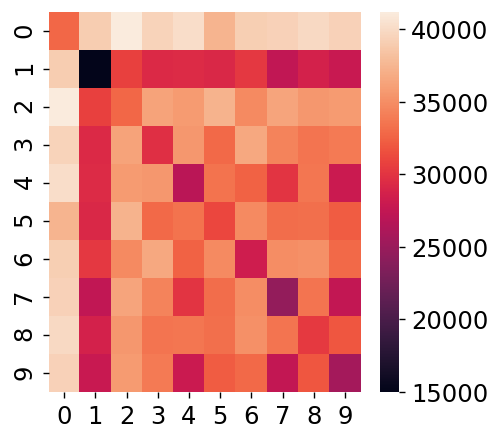

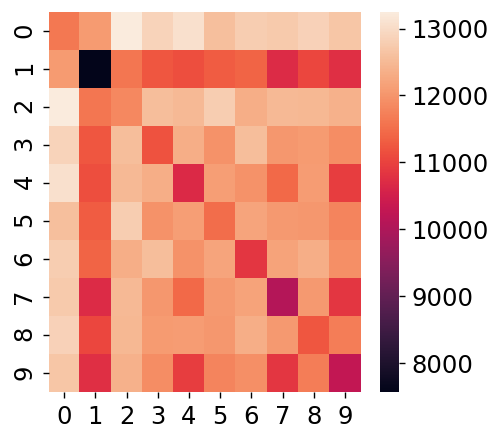

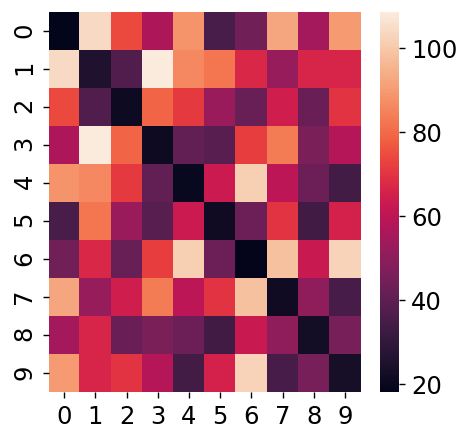

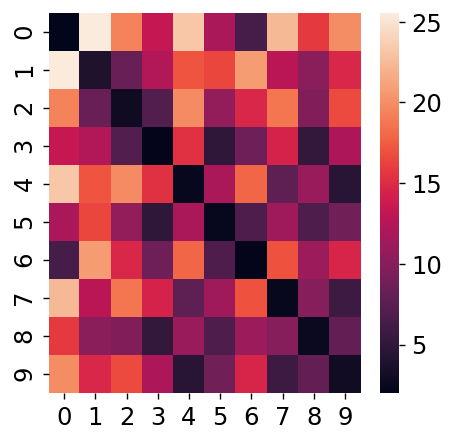

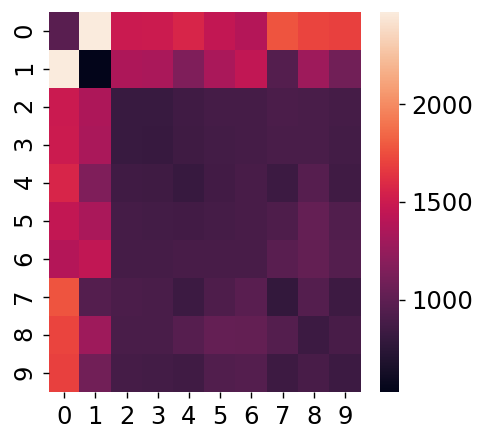

In [37]:
#Plot heatmap of distances
c = []
for i in latents:
  r = rankClus(i, digits.cpu().detach().numpy())
  c += [r]
  sns.heatmap(r)
  plt.show()

In [46]:
d50['Digit'] = np.unique(digits.numpy()).tolist()*4
d50.head()

,Latent,Tau,Digit
0,PCA 50D,0.822222,0
1,PCA 50D,0.866667,1
2,PCA 50D,0.866667,2
3,PCA 50D,0.822222,3
4,PCA 50D,0.955556,4


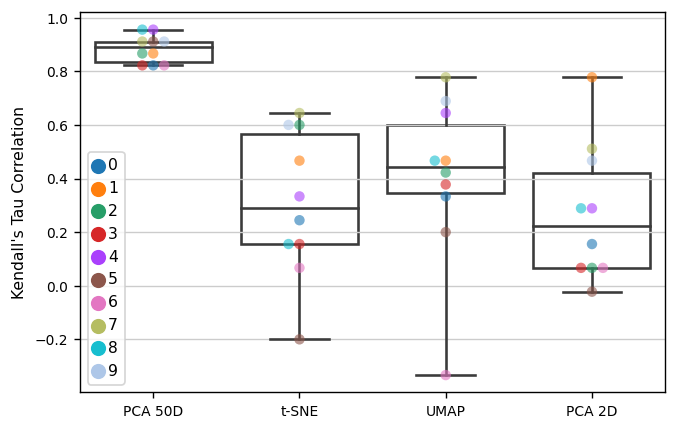

In [51]:
plotNeighSingle2(d50[~d50['Latent'].isin(['Ambient'])],size=6,figsize=(6,4),hue='Digit')

In [ ]:
inds = [[4,5,6]]#,[10,11,12],[16,17,18]]

dfs = []
for d in inds:
  dfs += [getAllNeigh([latents[i] for i in d],[latentLab[i] for i in d],[latentType[i] for i in d],meta.smartseq_cluster)]
d100 = pd.concat(dfs)
d100.head()

,Latent,Tau
0,PCA 100D t-SNE,0.296296
1,PCA 100D t-SNE,0.243386
2,PCA 100D t-SNE,0.179894
3,PCA 100D t-SNE,0.370370
4,PCA 100D t-SNE,0.386243


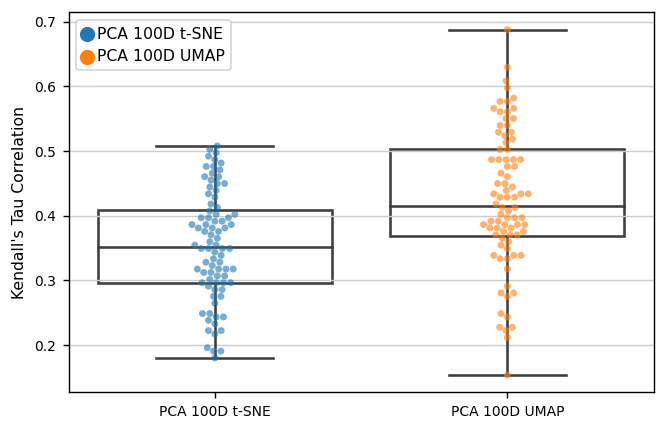

In [ ]:
plotNeighSingle(d100[~d100['Latent'].isin(['PCA 100D'])],size=4,figsize=(6,4))

### **Smart-seq Data**

In [ ]:
count_mat = sio.mmread(data_path+'/smartseq.mtx')
count_mat.shape

(3850, 1999)

In [ ]:
#Center and scale log-normalized data
scaled_mat = scale(count_mat)

In [ ]:
meta = pd.read_csv(data_path+'/smartmetadata.csv',index_col = 0)
meta.head()

,sample_name,smartseq_cluster_id,smartseq_cluster,sex_label,smartseq_cluster_color,medical_cond_label,cell_counts,n_genes,percent_mito,pass_count_filter,pass_mito_filter
SM-GE4R2_S062_E1-50,SM-GE4R2_S062_E1-50,46,Nr5a1_9|11 Rorb,M,#6C39A6,behavior - none,964371.56,9772,0.0,True,True
SM-GE4SI_S356_E1-50,SM-GE4SI_S356_E1-50,46,Nr5a1_9|11 Rorb,M,#6C39A6,behavior - none,973072.06,8253,0.0,True,True
SM-GE4SI_S172_E1-50,SM-GE4SI_S172_E1-50,46,Nr5a1_9|11 Rorb,M,#6C39A6,behavior - none,977132.60,9394,0.0,True,True
LS-15034_S07_E1-50,LS-15034_S07_E1-50,42,Nr5a1_4|7 Glipr1,M,#763BFF,behavior - none,948605.44,10643,0.0,True,True
LS-15034_S28_E1-50,LS-15034_S28_E1-50,42,Nr5a1_4|7 Glipr1,F,#763BFF,behavior - none,951803.00,10550,0.0,True,True


In [ ]:
lab1 = list(meta.smartseq_cluster)
lab2 = list(meta.sex_label)
lab3 = list(meta.medical_cond_label)


allLabs = np.array([lab1,lab2])

nanLabs = np.array([[np.nan]*len(lab1)])

#Shuffled labels for over-fitting check
shuff_lab1 = random.sample(lab1, len(lab1))  
shuff_lab2 = random.sample(lab2, len(lab2))  
shuff_allLabs = np.array([shuff_lab1,shuff_lab2])

clus_colors = list(pd.unique(meta.smartseq_cluster_color))

sex_colors = ['#abacb7','#F8C471']

In [ ]:
latents,latentLab,latentType = latentComp(scaled_mat, count_mat, ndims=2, pcs=[50,100], rounds = 3)

In [ ]:
latentLab

['Ambient',
 'PCA 50D',
 'PCA 50D t-SNE',
 'PCA 50D UMAP',
 'PCA 100D',
 'PCA 100D t-SNE',
 'PCA 100D UMAP',
 'PCA 50D',
 'PCA 50D t-SNE',
 'PCA 50D UMAP',
 'PCA 100D',
 'PCA 100D t-SNE',
 'PCA 100D UMAP',
 'PCA 50D',
 'PCA 50D t-SNE',
 'PCA 50D UMAP',
 'PCA 100D',
 'PCA 100D t-SNE',
 'PCA 100D UMAP']

Check internal distances in clusters

In [ ]:
allNeigh = getAllNeigh(latents,latentLab,latentType,meta.smartseq_cluster)
allNeigh.head()

,Latent,Tau
0,PCA 50D,0.751323
1,PCA 50D,0.656085
2,PCA 50D,0.719577
3,PCA 50D,0.777778
4,PCA 50D,0.788360


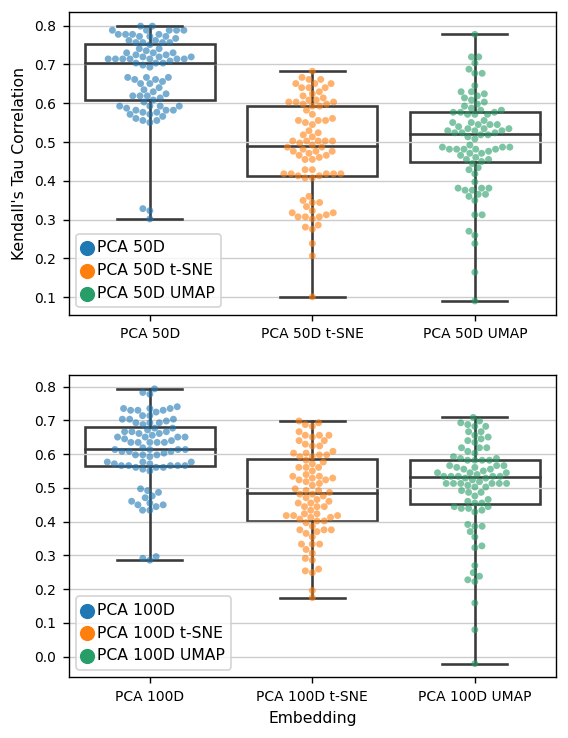

In [ ]:
plotNeigh(allNeigh,size=4)

In [ ]:
inds = [[1,2,3],[7,8,9],[13,14,15]]

dfs = []
for d in inds:
  dfs += [getAllNeigh([latents[i] for i in d],[latentLab[i] for i in d],[latentType[i] for i in d],meta.smartseq_cluster)]
d50 = pd.concat(dfs)
d50.head()

,Latent,Tau
0,PCA 50D t-SNE,0.280423
1,PCA 50D t-SNE,0.264550
2,PCA 50D t-SNE,0.253968
3,PCA 50D t-SNE,0.380952
4,PCA 50D t-SNE,0.433862


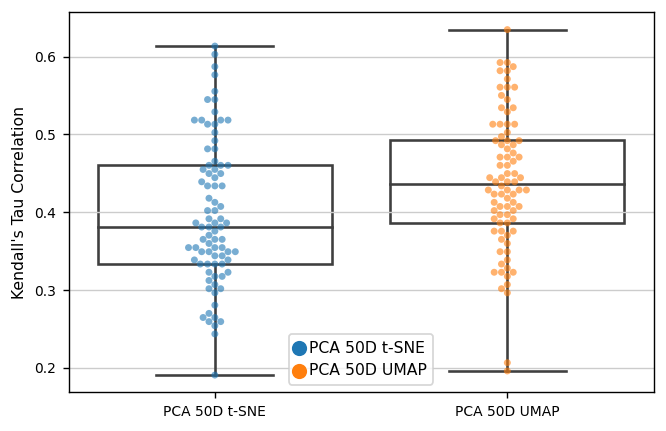

In [ ]:
plotNeighSingle(d50[~d50['Latent'].isin(['PCA 50D'])],size=4,figsize=(6,4))

In [ ]:
inds = [[4,5,6],[10,11,12],[16,17,18]]

dfs = []
for d in inds:
  dfs += [getAllNeigh([latents[i] for i in d],[latentLab[i] for i in d],[latentType[i] for i in d],meta.smartseq_cluster)]
d100 = pd.concat(dfs)
d100.head()

,Latent,Tau
0,PCA 100D t-SNE,0.296296
1,PCA 100D t-SNE,0.243386
2,PCA 100D t-SNE,0.179894
3,PCA 100D t-SNE,0.370370
4,PCA 100D t-SNE,0.386243


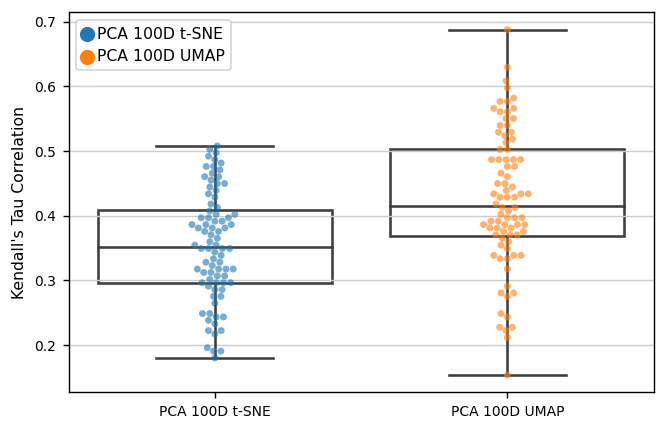

In [ ]:
plotNeighSingle(d100[~d100['Latent'].isin(['PCA 100D'])],size=4,figsize=(6,4))

Set Ambient Data

In [ ]:
allVals = getAllVars(latents,latentLab,latentType,meta.smartseq_cluster)
allVals.head()

,Latent,Distance,Value
0,Ambient,Inter-Type,1710.118347
1,Ambient,Inter-Type,1708.396743
2,Ambient,Inter-Type,1775.301201
3,Ambient,Inter-Type,1703.756703
4,Ambient,Inter-Type,1672.669783


In [ ]:
np.unique(allVals.Latent)

array(['Ambient', 'PCA 100D', 'PCA 100D UMAP', 'PCA 100D t-SNE',
       'PCA 50D', 'PCA 50D UMAP', 'PCA 50D t-SNE'], dtype=object)

Scale all distributions to same mean (from Ambient)

In [ ]:
test = allVals.copy()

In [ ]:
sub = test[test['Latent'].isin(['Ambient'])]
avg = np.mean(sub['Value'])

In [ ]:
dfs = []
for i in np.unique(test['Latent']):
  sub = test[test['Latent'].isin([i])]
  sub['Value'] = sub['Value'] - np.mean(sub['Value']) + avg
  #sub['Value'][sub['Distance'].isin(['Intra-Type'])] = sub['Value'][sub['Distance'].isin(['Intra-Type'])] - np.mean(sub['Value'][sub['Distance'].isin(['Intra-Type'])]) + avg
  sub['KS'] = [stats.ks_2samp(np.array(sub['Value'][sub['Distance'].isin(['Inter-Type'])].tolist()),np.array(sub['Value'][sub['Distance'].isin(['Intra-Type'])].tolist()))]*len(sub['Value'])

  
  dfs += [sub]

newVals = pd.concat(dfs)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Ks_2sampResult(statistic=0.9894179894179894, pvalue=1.2212453270876722e-15)
Ks_2sampResult(statistic=0.7905643738977073, pvalue=1.7763568394002505e-15)
Ks_2sampResult(statistic=0.9448853615520282, pvalue=1.7763568394002505e-15)
Ks_2sampResult(statistic=0.9514991181657848, pvalue=1.7763568394002505e-15)
Ks_2sampResult(statistic=0.9537037037037037, pvalue=1.7763568394002505e-15)
Ks_2sampResult(statistic=0.9171075837742504, pvalue=1.7763568394002505e-15)
Ks_2sampResult(statistic=0.9563492063492064, pvalue=1.7763568394002505e-15)


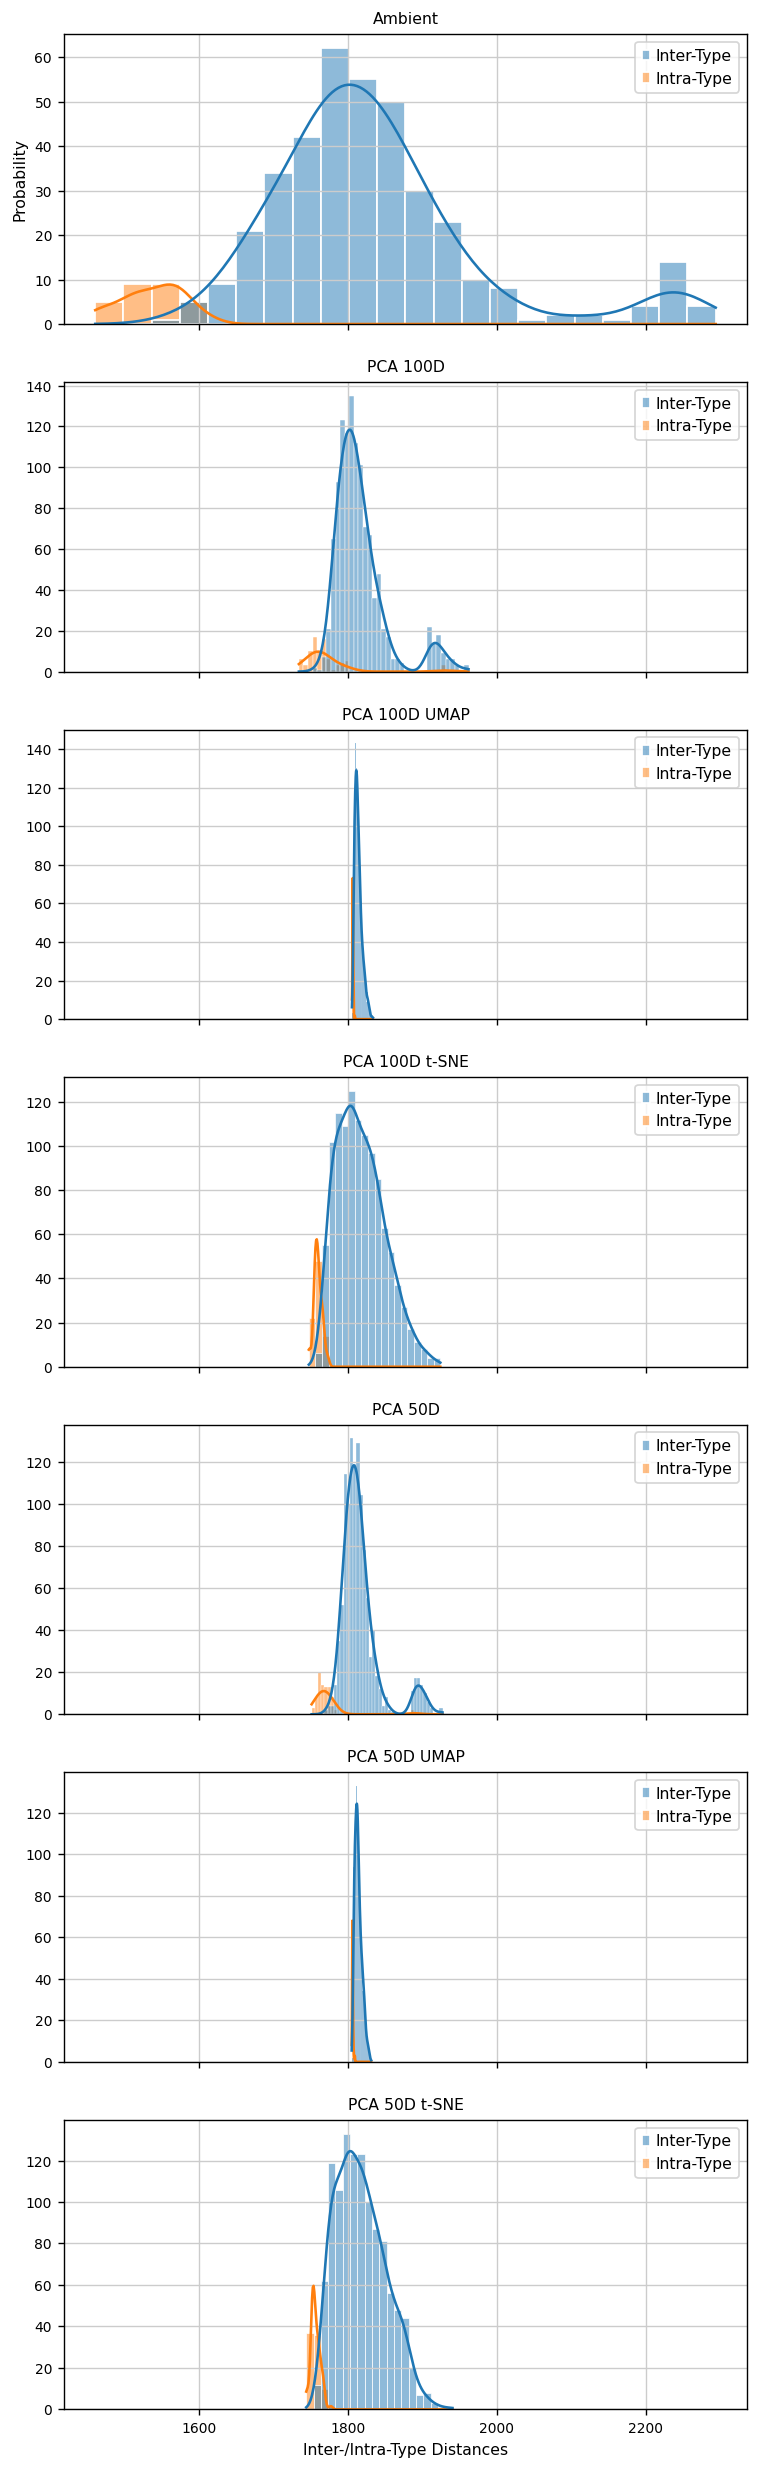

In [ ]:
plotAmb(newVals)

### **MERFISH data**

In [ ]:
counts = anndata.read(data_path+'/counts.h5ad')
print(counts)

cellMeta = pd.read_csv(data_path+'/metadata.csv')
print(cellMeta.head())

AnnData object with n_obs × n_vars = 280327 × 254
     Unnamed: 0  fovID     fov_x  ...     label     subclass    class_label
0  1.000010e+37     13  4539.310  ...   Astro_1   Astrocytes          Other
1  1.000020e+38    290 -4016.860  ...      Endo  Endothelial          Other
2  1.000070e+38    113   750.406  ...       SMC          SMC          Other
3  1.000070e+38    432  1262.680  ...      Endo  Endothelial          Other
4  1.000090e+38    354 -3627.450  ...  L23_IT_3       L23_IT  Glutamatergic

[5 rows x 12 columns]


In [ ]:
choice = np.unique(cellMeta.slice_id)[7] #7
choice

'mouse1_slice162'

In [ ]:
counts.obs['slice'] = pd.Categorical(cellMeta.slice_id)
counts.obs['type'] = pd.Categorical(cellMeta.subclass)
counts.obs['x'] = list(cellMeta.center_x)
counts.obs['y'] = list(cellMeta.center_y)

In [ ]:
sub = counts[counts.obs['slice'].isin([choice])]
print(sub)

colors = np.random.rand(len(sub.obs['type']),3)
nanLabs = np.array([[np.nan]*len(sub.obs['type'])])

labs = np.array([list(sub.obs['type'])])
labs_cont = np.array([list(sub.obs['x']),list(sub.obs['y'])])

View of AnnData object with n_obs × n_vars = 6963 × 254
    obs: 'slice', 'type', 'x', 'y'


In [ ]:
orig_mat = sub.X

In [ ]:
log_mat = np.log1p(sub.X)

In [ ]:
sc.pp.log1p(sub)

#Center scale
sc.pp.scale(sub, max_value=10)

scaled_mat = sub.X

/usr/local/lib/python3.7/dist-packages/scanpy/preprocessing/_simple.py:343: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [ ]:
latents,latentLab,latentType = latentComp(scaled_mat, log_mat, ndims=2, pcs=[50,100], rounds = 3)

Check how cluster neighbor rankings are maintained

In [ ]:
allNeigh = getAllNeigh(latents,latentLab,latentType,labs[0])
allNeigh.head()

,Latent,Tau
0,PCA 50D,0.666667
1,PCA 50D,0.620000
2,PCA 50D,0.760000
3,PCA 50D,0.820000
4,PCA 50D,0.580000


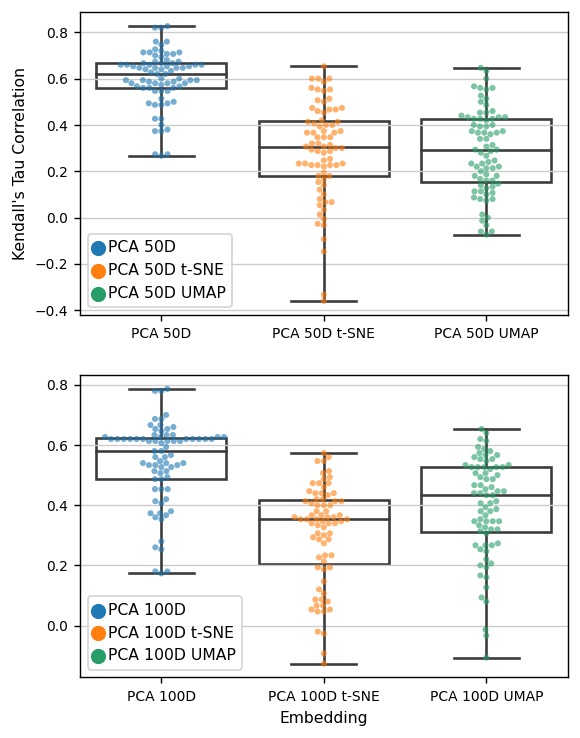

In [ ]:
plotNeigh(allNeigh)

In [ ]:
inds = [[1,2,3],[7,8,9],[13,14,15]]

dfs = []
for d in inds:
  dfs += [getAllNeigh([latents[i] for i in d],[latentLab[i] for i in d],[latentType[i] for i in d],labs[0])]
d50 = pd.concat(dfs)
d50.head()

,Latent,Tau
0,PCA 50D t-SNE,0.113333
1,PCA 50D t-SNE,0.493333
2,PCA 50D t-SNE,0.560000
3,PCA 50D t-SNE,0.533333
4,PCA 50D t-SNE,-0.053333


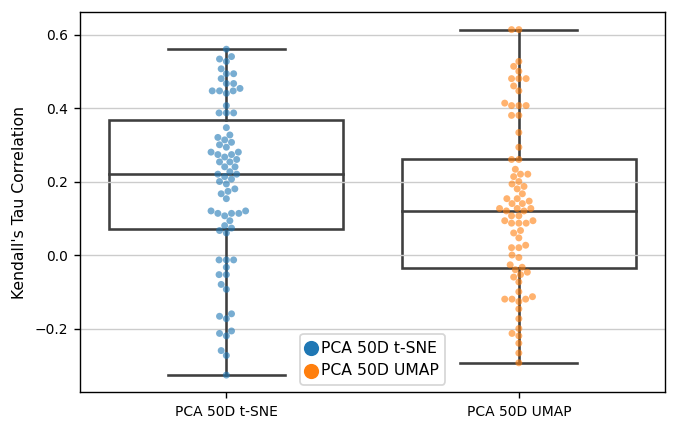

In [ ]:
plotNeighSingle(d50[~d50['Latent'].isin(['PCA 50D'])],size=4,figsize=(6,4))

In [ ]:
inds = [[4,5,6],[10,11,12],[16,17,18]]

dfs = []
for d in inds:
  dfs += [getAllNeigh([latents[i] for i in d],[latentLab[i] for i in d],[latentType[i] for i in d],labs[0])]
d100 = pd.concat(dfs)
d100.head()

,Latent,Tau
0,PCA 100D t-SNE,0.006667
1,PCA 100D t-SNE,0.266667
2,PCA 100D t-SNE,0.333333
3,PCA 100D t-SNE,0.206667
4,PCA 100D t-SNE,0.086667


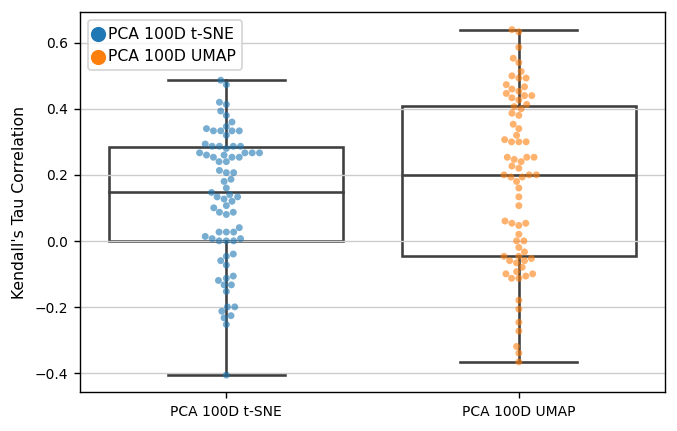

In [ ]:
plotNeighSingle(d100[~d100['Latent'].isin(['PCA 100D'])],size=4,figsize=(6,4))

In [ ]:
allVals = getAllVars(latents,latentLab,latentType,labs[0])
allVals.head()

,Latent,Distance,Value
0,Ambient,Inter-Type,75.082179
1,Ambient,Inter-Type,121.822145
2,Ambient,Inter-Type,114.060982
3,Ambient,Inter-Type,125.148162
4,Ambient,Inter-Type,119.639455


In [ ]:
np.unique(allVals.Latent)

array(['Ambient', 'PCA 100D', 'PCA 100D UMAP', 'PCA 100D t-SNE',
       'PCA 50D', 'PCA 50D UMAP', 'PCA 50D t-SNE'], dtype=object)

Scale all distributions to same mean (from Ambient)

In [ ]:
test = allVals.copy()

In [ ]:
sub = test[test['Latent'].isin(['Ambient'])]
avg = np.mean(sub['Value'])

In [ ]:
np.unique(test['Latent'])

array(['Ambient', 'PCA 100D', 'PCA 100D UMAP', 'PCA 100D t-SNE',
       'PCA 50D', 'PCA 50D UMAP', 'PCA 50D t-SNE'], dtype=object)

In [ ]:
dfs = []
for i in np.unique(test['Latent']):
  sub = test[test['Latent'].isin([i])]
  sub['Value'] = sub['Value'] - np.mean(sub['Value']) + avg
  #sub['Value'][sub['Distance'].isin(['Intra-Type'])] = sub['Value'][sub['Distance'].isin(['Intra-Type'])] - np.mean(sub['Value'][sub['Distance'].isin(['Intra-Type'])]) + avg
  sub['KS'] = [stats.ks_2samp(np.array(sub['Value'][sub['Distance'].isin(['Inter-Type'])].tolist()),np.array(sub['Value'][sub['Distance'].isin(['Intra-Type'])].tolist()))]*len(sub['Value'])

 
  
  dfs += [sub]

newVals = pd.concat(dfs)

Ks_2sampResult(statistic=0.84, pvalue=0.0)
Ks_2sampResult(statistic=0.68, pvalue=2.220446049250313e-16)
Ks_2sampResult(statistic=0.9733333333333334, pvalue=2.220446049250313e-16)
Ks_2sampResult(statistic=0.96, pvalue=2.220446049250313e-16)
Ks_2sampResult(statistic=0.8422222222222222, pvalue=2.220446049250313e-16)
Ks_2sampResult(statistic=0.9644444444444444, pvalue=2.220446049250313e-16)
Ks_2sampResult(statistic=0.96, pvalue=2.220446049250313e-16)


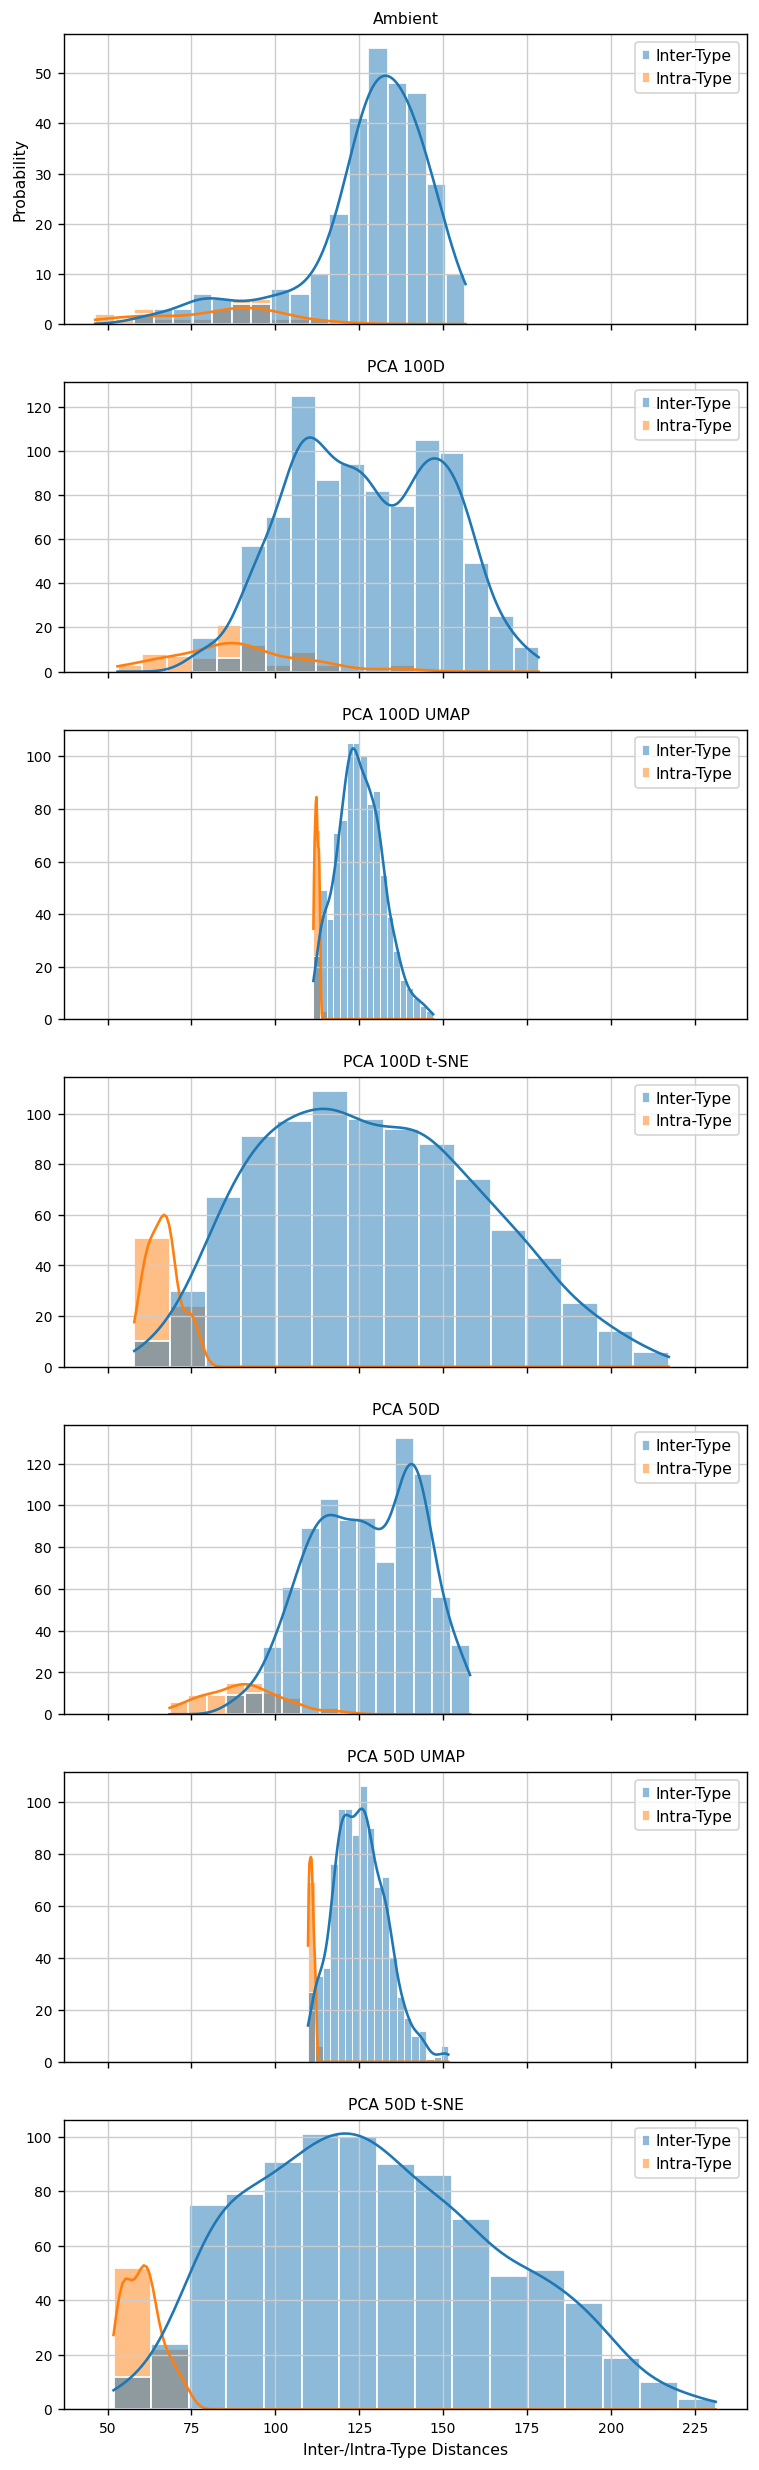

In [ ]:
plotAmb(newVals)

### **Ex Utero E8.5 data**

In [ ]:
cell_types = {'0': 'Blood', '1': 'Mixed Mesoderm', '2': 'Foregut', '3': 'Cardiac', '4': 'Mid Hind Brain',
'5': 'Endothelial', '6': 'Presomitic Mesoderm', '7':'Amnion', '8':'Extra-Embryonic Endoderm', '9':'Pharyngeal Mesoderm',
'10': 'Extra-Embryonic Ectoderm', '11': 'Blood' , '12':'Placodes', '13': 'Neural Tube', '14':'Extra-Embryonic Mesoderm',
'15':'Somitic Mesoderm', '16':'Neural Crest', '17':'Amnion', '18':'Mid Hind Gut'}

#Reading in log-normalized counts only


counts = pd.read_csv(data_path+'/GSE149372_scRNA.normalized.assay85.csv',index_col=0)
print(counts.head())

cellMeta = pd.read_csv(data_path+'/GSE149372_scRNA.MetaData.85.csv')
print(cellMeta.head())

#Center and scale log-normalized data
count_mat = counts.values.T

adata = anndata.AnnData(X = count_mat)
adata.obs_names = list(counts.columns)
adata.var_names = list(counts.index)
adata.obs['Utero'] = pd.Categorical(cellMeta.Utero)
adata.obs['Cluster'] = pd.Categorical(cellMeta.seurat_clusters)
adata

exAdata = adata[adata.obs['Utero']=='ExUt']
inAdata = adata[adata.obs['Utero']=='InUt']
exAdata

#In paper, use top 2000 HVGs and 15 PCs
def scaleAdata(adata):
  sc.pp.filter_cells(adata, min_counts=0)
  sc.pp.filter_genes(adata, min_counts=0)


  sc.pp.highly_variable_genes(adata,n_top_genes=2000)

  adata = adata[:,adata.var['highly_variable']]
  adata.obsm['log'] = adata.X

  sc.pp.scale(adata, max_value=10)
  return adata

adata = scaleAdata(adata)
exAdata = scaleAdata(exAdata)
inAdata = scaleAdata(inAdata)

toUseAdata = exAdata
count_mat = toUseAdata.obsm['log']
scaled_mat = toUseAdata.X

#Set colors for cell clusters
colors = np.random.rand(len(toUseAdata.obs['Cluster']),3)

labs = np.array([list(toUseAdata.obs['Cluster']),list(toUseAdata.obs['Utero'])])

# adata.obs['Cluster'].value_counts()
#

        AAACGAAAGTCCCGAC-1  ...  TTTGTTGGTTGCGGAA-4
Xkr4              0.000000  ...                 0.0
Rp1               0.000000  ...                 0.0
Sox17             0.000000  ...                 0.0
Mrpl15            1.175618  ...                 0.0
Lypla1            0.751450  ...                 0.0

[5 rows x 10290 columns]
           Unnamed: 0 orig.ident  ...  seurat_clusters  integrated_snn_res.0.5
0  AAACGAAAGTCCCGAC-1       p8.5  ...               13                      13
1  AAACGAAGTCGAGTTT-1       p8.5  ...               15                      15
2  AAACGCTAGGACTTCT-1       p8.5  ...               10                      10
3  AAACGCTCAACGCCCA-1       p8.5  ...               12                      12
4  AAACGCTTCTGTGCGG-1       p8.5  ...                8                       8

[5 rows x 9 columns]


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


In [ ]:
latents,latentLab,latentType = latentComp(scaled_mat, count_mat, ndims=2, pcs=[50,100], rounds = 3)

Check ranking of cluster neighbors

In [ ]:
allNeigh = getAllNeigh(latents,latentLab,latentType,labs[0])
allNeigh.head()

,Latent,Tau
0,PCA 50D,0.847953
1,PCA 50D,0.859649
2,PCA 50D,0.789474
3,PCA 50D,0.859649
4,PCA 50D,0.871345


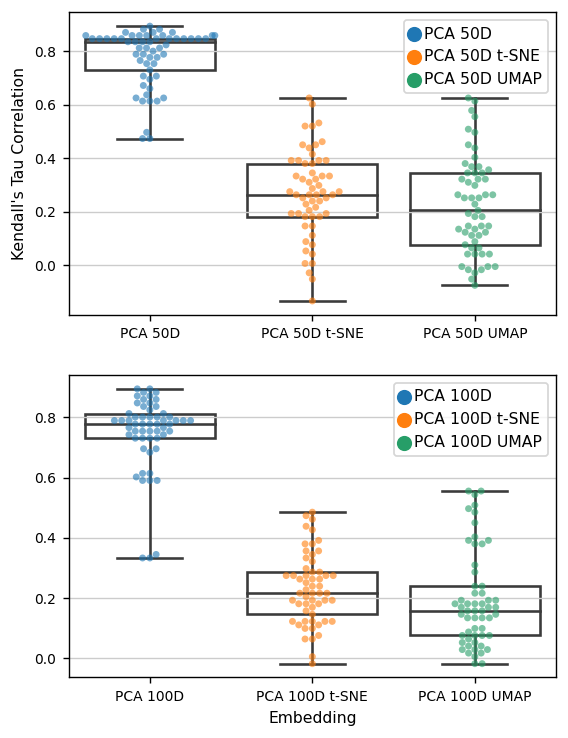

In [ ]:
plotNeigh(allNeigh,size=4)

In [ ]:
inds = [[1,2,3],[7,8,9],[13,14,15]]

dfs = []
for d in inds:
  dfs += [getAllNeigh([latents[i] for i in d],[latentLab[i] for i in d],[latentType[i] for i in d],labs[0])]
d50 = pd.concat(dfs)
d50.head()

,Latent,Tau
0,PCA 50D t-SNE,0.251462
1,PCA 50D t-SNE,0.239766
2,PCA 50D t-SNE,0.321637
3,PCA 50D t-SNE,0.239766
4,PCA 50D t-SNE,-0.029240


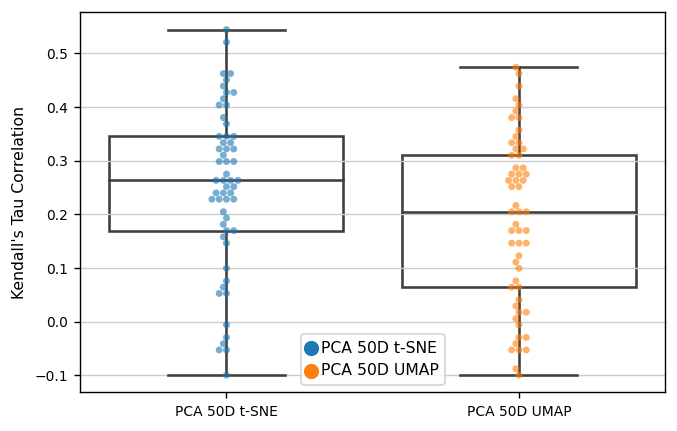

In [ ]:
plotNeighSingle(d50[~d50['Latent'].isin(['PCA 50D'])],size=4,figsize=(6,4))

In [ ]:
inds = [[4,5,6,],[10,11,12],[16,17,18]]
dfs = []
for d in inds:
  dfs += [getAllNeigh([latents[i] for i in d],[latentLab[i] for i in d],[latentType[i] for i in d],labs[0])]
d100 = pd.concat(dfs)
d100.head()

,Latent,Tau
0,PCA 100D t-SNE,0.076023
1,PCA 100D t-SNE,0.040936
2,PCA 100D t-SNE,0.181287
3,PCA 100D t-SNE,0.157895
4,PCA 100D t-SNE,0.017544


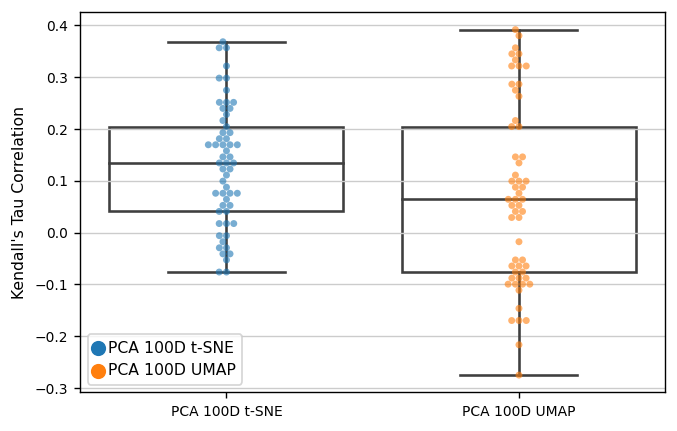

In [ ]:
plotNeighSingle(d100[~d100['Latent'].isin(['PCA 100D'])],size=4,figsize=(6,4))

In [ ]:
allVals = getAllVars(latents,latentLab,latentType,labs[0])
allVals.head()

,Latent,Distance,Value
0,Ambient,Inter-Type,198.212036
1,Ambient,Inter-Type,229.113797
2,Ambient,Inter-Type,139.893325
3,Ambient,Inter-Type,244.803672
4,Ambient,Inter-Type,203.088811


Scale all distributions to same mean (from Ambient)

In [ ]:
test = allVals.copy()

In [ ]:
sub = test[test['Latent'].isin(['Ambient'])]
avg = np.mean(sub['Value'])

In [ ]:
dfs = []
for i in np.unique(test['Latent']):
  sub = test[test['Latent'].isin([i])]
  sub['Value'] = sub['Value'] - np.mean(sub['Value']) + avg
  #sub['Value'][sub['Distance'].isin(['Intra-Type'])] = sub['Value'][sub['Distance'].isin(['Intra-Type'])] - np.mean(sub['Value'][sub['Distance'].isin(['Intra-Type'])]) + avg
  sub['KS'] = [stats.ks_2samp(np.array(sub['Value'][sub['Distance'].isin(['Inter-Type'])].tolist()),np.array(sub['Value'][sub['Distance'].isin(['Intra-Type'])].tolist()))]*len(sub['Value'])

  
  dfs += [sub]

newVals = pd.concat(dfs)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Ks_2sampResult(statistic=0.43859649122807015, pvalue=0.0018109152185037392)
Ks_2sampResult(statistic=0.48927875243664715, pvalue=9.587441951453002e-12)
Ks_2sampResult(statistic=0.8440545808966862, pvalue=3.5993146441616727e-32)
Ks_2sampResult(statistic=0.9005847953216374, pvalue=1.450887503578062e-36)
Ks_2sampResult(statistic=0.6042884990253411, pvalue=1.071030992433716e-16)
Ks_2sampResult(statistic=0.884990253411306, pvalue=2.52568023287664e-35)
Ks_2sampResult(statistic=0.9044834307992202, pvalue=7.047924971184153e-37)


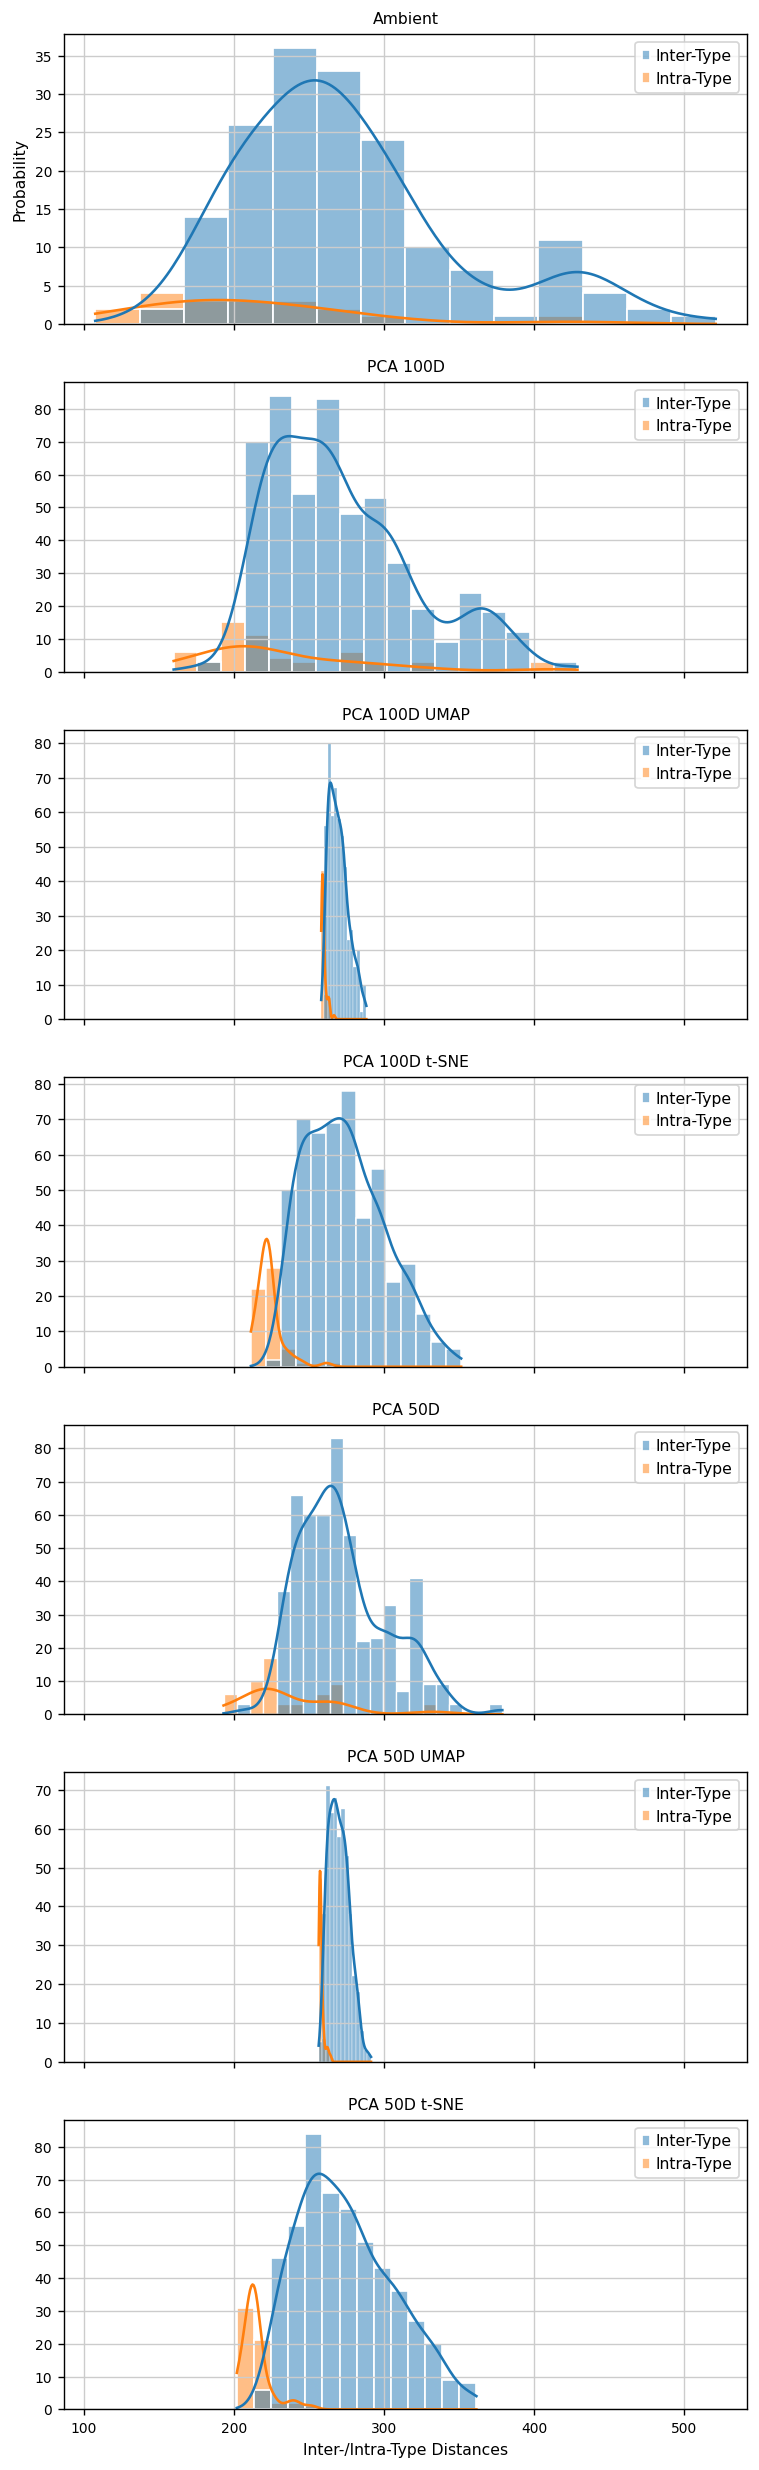

In [ ]:
plotAmb(newVals)